In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Bifurcations de populations de neurones
======================

Le but de ce projet est de simuler l'évolution de l'activité moyenne de groupes de neurones en intéraction, à l'aide d'un modèle simplifié de *Wilson-Cowan*. En notant $x=(x_1,...,x_i,..., x_n)\in \mathbb{R}^n$ le vecteur contenant l'activité moyenne de chacun des $n$ groupes de neurones, ce modèle s'écrit (en grandeurs normalisées)
$$
\tau \dot x = - x + S(Wx + d^{\rm ext})
$$
où $\tau$ est une constante de temps, $W \in \mathbb{R}^{n\times n}$ est une matrice décrivant les intéractions entre groupes de neurones, $d^{\rm ext}\in \mathbb{R}^n$ peut contenir des stimulis/perturbations extérieurs impactant chaque groupe, et $S: \mathbb{R}^n \to \mathbb{R}^n$ est de la forme
$$
S({\rm x}_1,...,{\rm x}_i ,...,{\rm x}_n) = (s_1({\rm x}_1),...,s_i({\rm x}_i),...,s_n({\rm x}_n))
$$
où $s_i:\mathbb{R}\to \mathbb{R}$ sont des fonctions dîtes d'*activation*.

Ces fonctions d'activation permettent de modéliser le fait que l'activité environnante d'un groupe de neurone doit atteindre un certain seuil avant d'exciter ce groupe. Des choix courants de fonctions d'activation sont la tangente hyperbolique ou des sigmoides de la forme
$$
s({\rm x}) = \frac{1}{1+ e^{-a(x-\theta)}}-\frac{1}{1+e^{a\theta}}
$$
où $\theta$ représente le seuil d'activation et $a$ sa pente, comme illustré ci-dessous. 

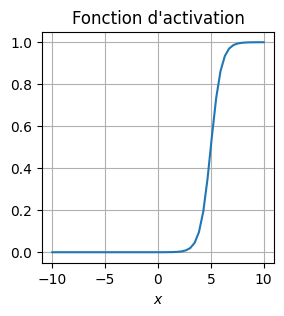

In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-a*(x-theta)))-1/(1+np.exp(a*theta))


a = 2.0   # la pente au niveau du seuil est a/4
theta = 5.0  # seuil
x = np.linspace(-10,10)
plt.figure()
plt.plot(x,sigmoid(x))
plt.grid(True)
plt.xlabel('$x$')
plt.title("Fonction d'activation")
plt.show()

Notons que si l'on réécrit l'équation différentielle composante par composante, on trouve que la dynamique de chaque groupe de neurone s'écrit
$$
\tau \dot x_i = -x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)
$$

**Question 1** Justifier que si les fonctions d'activation $s_i:\mathbb{R}\to \mathbb{R}$ sont bornées (minorées et majorées) alors toutes les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$ et sont bornées. Relier la borne de $t\mapsto x_i(t)$ à la borne de $s_i$ pour chaque $i$. 


**Réponse 1** : Le théorème d'existance globale garantit que les solutions maximales sont définies sur $\mathbb{R}$ car $$\Vert \dot x \Vert \leq \frac{1}{\tau} \Vert x \Vert + \frac{||G||}{\tau}$$ avec $\frac{1}{\tau}$ et G étant des constantes donc ne dépendent que de t, cela est possible car les $s_i$ sont bornées.

Soit $x(t)$ la solution on pose $g(t)=s(x(t),t)$ alors $g$ peut être bornée par une matrice colonne notée $G$ constante du temps qui est composée des bornes de $s_i$ notées $G_i$. $x$ est solution de $\tau \dot x = -x + g(t)$, soit pour chaque $x_i$ : $\tau \dot x_i = -x_i + g_i(t)$. on a donc pour chaque $x_i$ $$ \frac {-x_i - G_i}{\tau} \leq \dot x_i \leq \frac {-x_i + G_i}{\tau}$$ 
d'où : $$ C_2 e^{\frac{-t}{\tau}} - G_i \leq x_i(t) \leq C_1 e^{\frac{-t}{\tau}} + G_i$$avec $C_1$ et $C_2$ des constantes
Donc tous les $x_i$ sont bornés pour $0 \leq t$, d'où $x$ est bornée.
De plus $\lim\limits_{t \to 0} e^{\frac{-t}{\tau}} = 0$ donc asymtotiquement $x_i$ est bornée par $G_i$ 


Pour simplifier, on étudie ce système en dimension 2, c'est-à-dire avec deux groupes de neurones: le premier ayant un effet *excitant* et le deuxième *inhibant*. On traduit cela par la matrice d'interconnection suivante.

In [4]:
W = np.array([[5.0, -4.0], [8.0, -1.0]])
print(W)

[[ 5. -4.]
 [ 8. -1.]]


On fixe aussi $s_1=s_2$ données par la sigmoide ci-dessus, ainsi que $\tau=1$ puisque faire varier $\tau$ ne change que l'échelle de temps. On va essayer d'étudier et exploiter la grande richesse de comportements asymptotiques possibles pour différentes valeurs de $d^{\rm ext}$.

Points d'équilibre
================

On commence par considérer $d^{\rm ext}$ constant. Ses composantes $d_1^{\rm ext}$ et $d_2^{\rm ext}$ peuvent donc être vus comme des paramètres du système. Les points d'équilibre $x^{\rm eq}\in \mathbb{R}^n$ se caractérisent alors par l'équation
$$
x^{\rm eq} = S(W x^{\rm eq} + d^{\rm ext})
$$
La fonction suivante trace les points $(x_1,x_2)$ tels que $-x_1+s(w_{11}x_1+w_{12}x_2+d_1^{\rm ext})=0$ (en rouge) et $-x_2+s(w_{21}x_1+w_{22}x_2+d_2^{\rm ext})=0$ (en vert) pour des valeurs de $d^{\rm ext}$ à choisir.

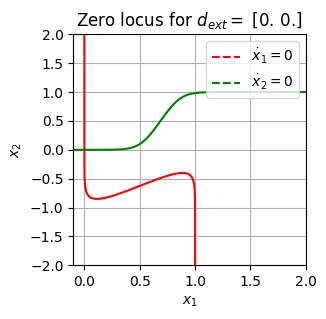

In [5]:
def plot_zero_locus(d_ext):
    grid_x1 = np.linspace(-0.1,2.0,100)
    grid_x2 = np.linspace(-2.0,2.0,100)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    plt.figure()
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()
    return


d_ext = np.array([0.0,0.0])  # A CHOISIR
plot_zero_locus(d_ext)

**Question 2** Identifier le point d'équilibre du système pour $d^{\rm ext}=0$ et étudier sa stabilité.

**Réponse 2** : Le point d'équilibre est $(x_{1},x_{2})=(0,0)$ car c'est là que $\dot x_{1}$ et $\dot x_{2}$ s'annulent. Pour étudier la stabilité on calcule la Jacobienne de $f(x)=-x+s(x)$ 

On a :

$\frac{\partial f_{1}} {\partial x_{1}} (x_1, x_2) = -1 + \frac{5ae^{-a (5x_{1} - 4x_{2} + d^{\rm ext}_{1} - \theta)}}{({1 + e^{-a (5x_{1} - 4x_{2} + d^{\rm ext}_{1} - \theta)})}^2}$

$\frac{\partial f_{1}} {\partial x_{2}} (x_1, x_2) = \frac{-4ae^{-a (5x_{1} - 4x_{2} + d^{\rm ext}_{1} - \theta)}}{({1 + e^{-a (5x_{1} - 4x_{2} + d^{\rm ext}_{1} - \theta)})}^2}$

$\frac{\partial f_{2}} {\partial x_{1}} (x_1, x_2) = \frac{8ae^{-a (8x_{1} - x_{2} + d^{\rm ext}_{2} - \theta)}}{({1 + e^{-a (8x_{1} - x_{2} + d^{\rm ext}_{2} - \theta)})}^2}$

$\frac{\partial f_{1}} {\partial x_{1}} (x_1, x_2) = -1 + \frac{-ae^{-a (8x_{1} - x_{2} + d^{\rm ext}_{2} - \theta)}}{({1 + e^{-a (8x_{1} - x_{2} + d^{\rm ext}_{2} - \theta)})}^2}$

Donc on peut calculer sa matrice jacobienne en tout point grâce au programmme suivant et ainsi trouver ses valeurs propres :

In [6]:
def jacobian_dynamics(x1,x2,d_ext):
    return np.array([[-1 + (5*a*np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))/(1 + np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))**2, (-4*a*np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))/(1 + np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))**2], [(8*a*np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))/(1 + np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))**2, -1 + (-a*np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))/(1 + np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))**2]])

J = jacobian_dynamics(0, 0, np.array([0, 0]))
V = np.linalg.eigvals(J)
print(V)

[-0.99981842+0.00043542j -0.99981842-0.00043542j]


Les parties réelles des valeurs propres de la jacobienne sont bien strictements négatives donc le point (0, 0) est un point d'équilibre stable.

**Question 3** Tester d'autres valeurs de $d^{\rm ext}$. Par exemple, fixer $d^{\rm ext}_2=4$, et faire varier $d^{\rm ext}_1$ entre 3 et 8. Qu'observe-t-on sur le nombre de points d'équilibre ? Pour $d^{\rm ext}=(6,4)$, on trace ci-dessous le portrait de phase. Retrouver graphiquement les points d'équilibre et intuiter leur stabilité. Quels sont les seuls comportements asymptotiques possibles des solutions pour cette valeur constante de $d^{\rm ext}$ ?

**Réponse 3** : On trace si dessous les points $(x_{1},x_{2})$ tels que $\dot x_{1}=0$ et $\dot x_{2}=0$ pour $d^{\rm ext}_2=4$, et $d^{\rm ext}_1$ variant entre 3 et 8. On retrouve graphiquement les points d'équilibres, ils corespondent aux intersections entre la courbe rouge et la courbe verte.
On estime donc par lecture graphique les points d'équilibre suivants:
- $d^{\rm ext}=(3,4)$ : $(x_{1},x_{2})= (0.0,0.15)$
- $d^{\rm ext}=(4,4)$ : $(x_{1},x_{2})= (0.05,0.2)$
- $d^{\rm ext}=(5,4)$ : $(x_{1},x_{2})= (0.2,0.45)$
- $d^{\rm ext}=(6,4)$ : $(x_{1},x_{2})= (0.25,0.7)$, $(x_{1},x_{2})= (0.7,1.0)$ et $(x_{1},x_{2})= (0.98,1.0)$
- $d^{\rm ext}=(7,4)$ : $(x_{1},x_{2})= (1.0,1.0)$
- $d^{\rm ext}=(8,4)$ : $(x_{1},x_{2})= (1.0,1.0)$

Il y a donc 1 point d'équilibre sur tous les cas sauf pour $d^{\rm ext}=(6,4)$, on observe graphiquement que la courbe rouge est translatée vers le haut lorsqu'on modifie $d^{\rm ext}_1$, il y aura donc également des valeurs de $d^{\rm ext}$ tel qu'il y ait 2 points d'équilibre pour une valeur de $d^{\rm ext}_1$ entre 5 et 6 et entre 6 et 7.


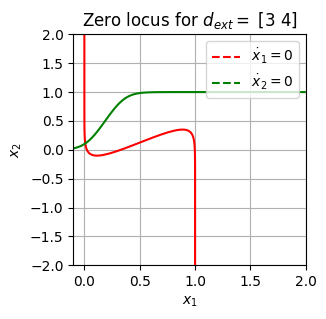

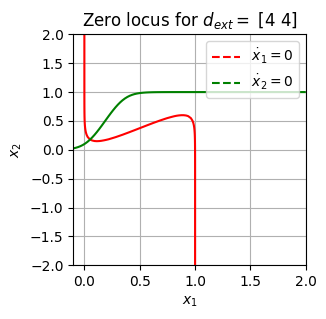

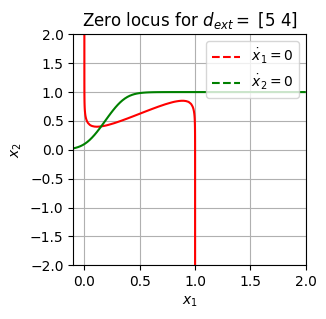

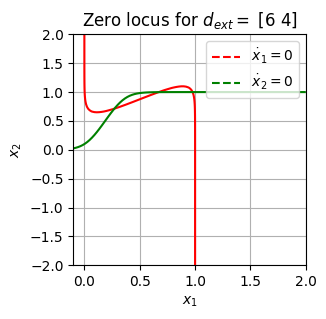

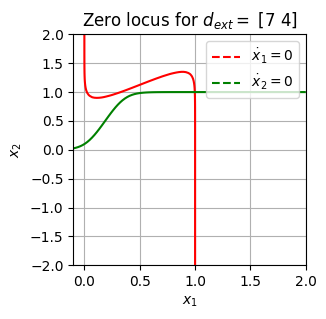

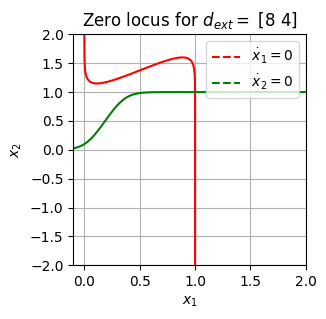

In [7]:
for x in range(3,9):
    d_ext = np.array([x, 4])
    plot_zero_locus(d_ext)

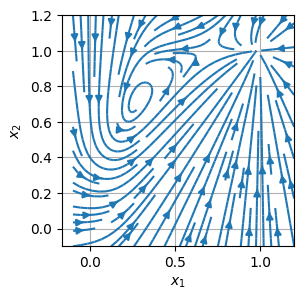

In [8]:
d_ext = np.array([6.0,4.0])  

grid_x1 = np.linspace(-0.1,1.2,70)
grid_x2 = np.linspace(-0.1,1.2,70)
X1, X2 = np.meshgrid(grid_x1,grid_x2)

X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

plt.figure()
plt.streamplot(grid_x1, grid_x2, X1dot, X2dot)
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

**Réponse 3 (suite):** En observant ce portrait de phase ci-dessous, on retrouve, pour $d^{\rm ext}=(6,4)$, les mêmes points d'equilibre que sur le graphique tracé plus haut, ils correspondent aux zones de convergence et de divergence des lignes de champs. On arrive ainsi à intuiter leur stabilité, si les lignes de champs convergent vers le point ils sont stables, si elles divergent ils sont instables. On obtient donc:
- $(x_{1},x_{2})= (0.25,0.7)$ point d'équilibre stable
- $(x_{1},x_{2})= (0.7,1.0)$ point d'équilibre instable 
- $(x_{1},x_{2})= (0.98,1.0)$ point d'équilibre stable
  
Si la solution est initialisé sur le point d'équilibre instable alors elle y reste, sinon la solution converge vers l'un des deux points d'équilibre stable.

Lorsque le nombre et la nature (stabilité) des points d'équilibre changent brusquement avec des modifications de paramètres, on parle de *bifurcation*. De tels phénomènes permettent généralement de produire des comportements asymptotiques extrêmement riches et variés, simplement en faisant varier ces paramètres. Nous en étudions plusieurs exemples dans la suite.

Simulation des trajectoires
================

**Question 4** Compléter la fonction ``solve_euler_explicit`` ci-dessous prenant en entrée une fonction $f: \mathbb{R}\times\mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant le vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$.

In [9]:
def solve_euler_explicit(f, x0, dt, t0, tf):
    temps=np.arange(t0,tf,dt)
    X=np.zeros(shape=(len(temps),2))
    X[0]=x0
    for i in range(1,len(temps)):
        X[i]=f(temps[i-1],X[i-1])*dt + X[i-1]
    return temps, X

**Question 5** Expliquer (sans le faire) comment on pourrait trouver numériquement l'ordre de convergence de ce schéma.


**Réponse 5** : L'ordre de convergence est le plus grand p tel que : $$ \max \limits_{1 \leq j \leq J} \Vert x^{\rm j}_{explicite} - x^{\rm j}_{euler}\Vert \leq c_v (dt)^p $$ 
Pour trouver l'ordre de convergence de ce schéma, il faut utiliser une fonction explicite (dont on connait les valeurs exactes) régie par une équation différentielle. On fait fonctionner notre algorithme d'Euler avec cette équation différentielle et les mêmes points de départ pour le plus de pas dt possibles. On calcule ensuite l'erreur maximale pour chaque dt : la différence maximale entre les points de la solution exacte et ceux donnés par l'algorithme. Puis on trace le logarithme de l'erreur en fonction de dt. On effectue une regression linéaire et la pente obtenue donne p.


**Question 6** On utilise maintenant ``solve_euler_explicit`` pour simuler des trajectoires de neurones lorsque $d^{\rm ext}$ est constant. En vous aidant du portrait de phase de la question 3, illustrer les comportements asymptotiques possibles des solutions pour $d^{\rm ext}=(6,4)$, en choisissant différentes conditions initiales. Lequel ne peut-on pas illustrer numériquement ?

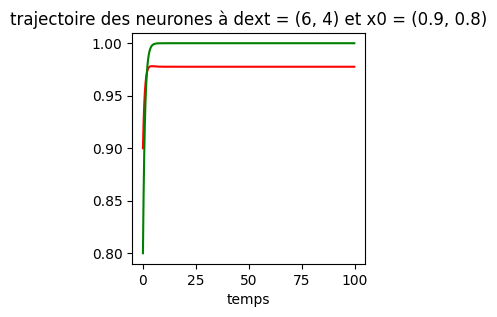

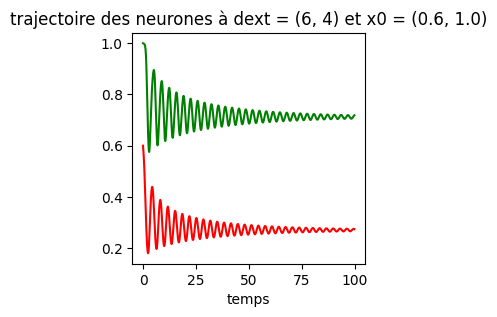

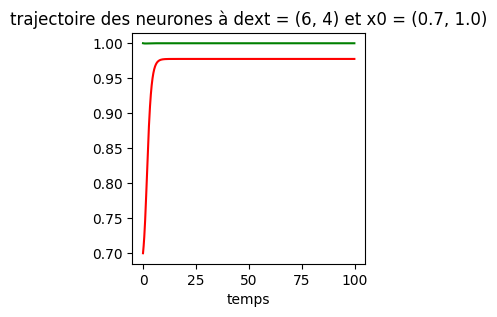

In [10]:
def f_d_ext_constant(t,x):
    d_ext = np.array([6.0,4.0])
    return -x + sigmoid(np.dot(W,x)+d_ext)



dt = 0.1
t0, tf = 0.0, 100.0

def trace_sol(x0):
    time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)
    plt.figure()
    plt.plot(time,x[:,0], label = '1e variable de x', color="red")
    plt.plot(time, x[:,1], label = '2e variable de x', color="green")
    plt.title("trajectoire des neurones à dext = (6, 4) et x0 = (" + str(x0[0]) + ", " + str(x0[1]) + ")")
    plt.xlabel("temps")
    plt.show()


trace_sol(np.array([0.9,0.8]))
trace_sol(np.array([0.6,1]))
trace_sol(np.array([0.7,1]))

**Réponse 6** : On retrouve bien les points d'équilibres stables (0.98, 1.0) et (0.25, 0.7) avec les 2 premiers tracés. Mais on ne peut pas mettre en évidence le point d'équilibre (0.7, 1.0), ce qu'on a essayé de faire avec la dernière figure. En effet, même en mettant comme condition initiale le point  (0.7, 1.0), les trajectoires ne restent pas constantes. Cela est dû au fait que le point d'équilibre est instable, une seule petite erreur numérique fait basculer les trajectoires hors du point d'équilibre en les faisant converger vers un des points d'équilibre stable (le point (0.98, 1.0) dans notre cas).

**Question 7** On fixe maintenant $d_2^{\rm ext}=8$ et on fait varier $d_1^{\rm ext}$ lentement de 4 à 8, puis de 8 à 4. En utilisant ``plot_zero_locus``, justifier le comportement de la solution obtenue. Tracer la solution en fonction de $d_1^{\rm ext}$, comment appelle-t-on ce phénomène ? Justifier que l'on parle de *mémoire courte*.

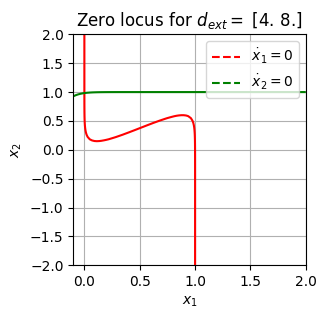

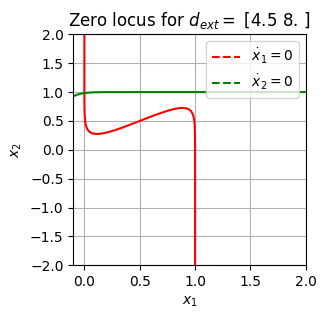

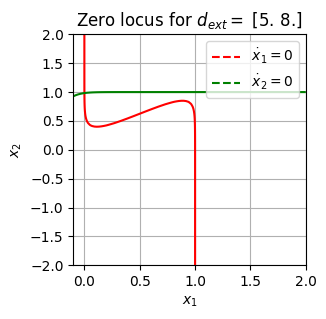

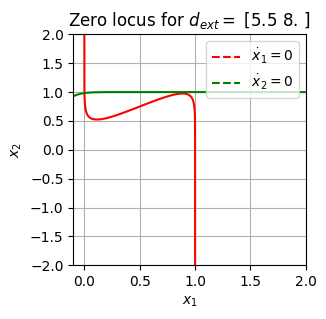

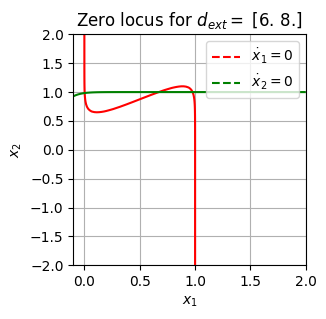

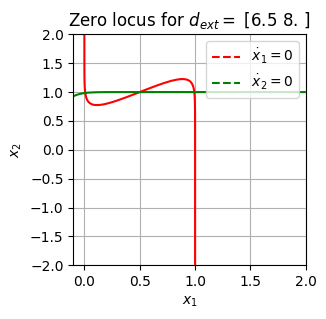

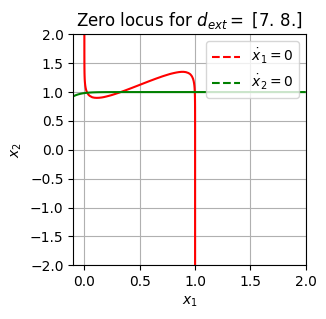

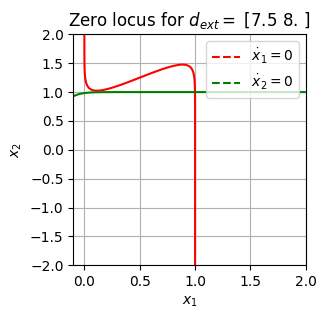

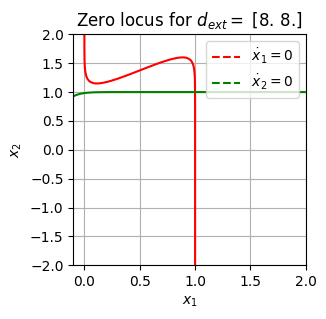

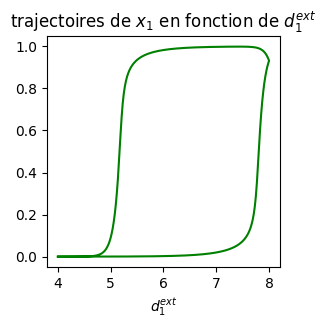

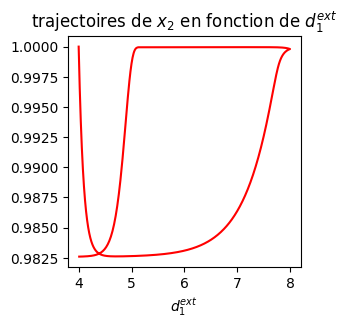

In [11]:
def d_ext_varying(t):
    d1_ext = (0.1*t+4)*(t<40)+(8-0.1*(t-40))*(t>=40)
    d2_ext = 8.0*np.ones(np.shape(t))
    return np.array([d1_ext,d2_ext])

def f_d_ext_varying(t,x):
    return -x + sigmoid(np.dot(W,x)+d_ext_varying(t))

for x in [0.5*i+4 for i in range(9)]:
    d_ext = np.array([x, 8])
    plot_zero_locus(d_ext)

x0 = np.array([0.0,1.0])
dt = 0.1
t0, tf = 0.0, 80.0
time, x = solve_euler_explicit(f_d_ext_varying, x0, dt, t0, tf)
plt.figure()
plt.plot((0.1*time+4)*(time<40)+(8-0.1*(time-40))*(time>=40), x[:,0], 'g', label = "x_1")
plt.xlabel('$d^{ext}_1$')
plt.title('trajectoires de $x_1$ en fonction de $d^{ext}_1$')
plt.show()
plt.figure()
plt.plot((0.1*time+4)*(time<40)+(8-0.1*(time-40))*(time>=40), x[:,1], 'r', label = "x_2")
plt.xlabel('$d^{ext}_1$')
plt.title('trajectoires de $x_2$ en fonction de $d^{ext}_1$')
plt.show()

**Réponse 7** : 
On observe un cycle d'hystérésis pour $x_1$ et $x_2$, ce qui correspond à ce qu'on peut déduire en utilisant ``plot_zeros_locus``. En effet la fonction ``plot_zero_locus`` permet de déterminer 2 points d'équilibre stable séparés par un point d'équilibre instable pour $d^{\rm ext}_1$ entre 5.5 et 7.5 . La solution $x$ va donc pouvoir être attirée pour une même valeur de $d^{\rm ext}_1$ vers l'un ou l'autre des points d'équilibre stable, mais comme ils sont stables $x$ va rester sur le point d'équilibre où elle se trouve avec la variation de $d^{\rm ext}$ jusqu'a ce que ce point n'existe plus, à savoir au delà de $d^{\rm ext}_1$=7.5 pour $d^{\rm ext}_1$ croissant et en dessous de $d^{\rm ext}_1$=5.5 pour $d^{\rm ext}_1$ décroissant. C'est bien ce que l'on observe sur les graphes des trajectoires de $x_1$ et $x_2$.  
L'hystérésis peut être utilisé comme une mémoire courte parce que pour une même valeur de $d^{\rm ext}_1$, $x_1$ peut avoir 2 valeurs différentes dépendant de ce qu'il y avait avant en mémoire (l'ancienne valeur de $d^{\rm ext}_1$ ou l'ancienne valeur de x par exemple).

Bendixon et cycle limite
============================

On cherche maintenant à faire apparaître un cycle limite oscillatoire. On s'appuie pour cela sur le théorème de *Bendixon* qui décrit le comportement possible de solutions bornées d'équations différentielles en dimension 2:

    ''Pour une équation différentielle de dimension 2 définie par une fonction continument différentiable, toute solution maximale bornée converge soit vers un point soit vers une fonction périodique du temps appelée *cycle limite*''
    
**Question 8** Justifier que l'on recherche alors une valeur de $d_{\rm ext}$ pour laquelle le système admet un seul point d'équilibre et pour laquelle ce point est instable. 

**Réponse 8** : Selon le théorème énoncé ci-dessus, on cherche une valeur de $d_{\rm ext}$ pour laquelle le système ne converge pas vers un point (donc ne possède pas de points d'équilibre attractif) afin de pouvoir observer le cycle limite.  
Or on a plus de chance de trouver un pont d'équilibre non attractif parmis les points d'équilibre instable car le moyen utilisé pour justifier la stabilité d'un point est le théorème du lien entre stabilité et stabilité du linéarisé tangent qui donne directement la stabilité asymptotique et donc l'attractivité.  
De plus il vaut mieux chercher une valeur de $d_{\rm ext}$ avec un seul point d'équlibre car on a donc d'autant plus de chance qu'il n'y ait pas de point d'équlibre attractif.  
Mais cette condition de point d'unique point d'équilibre et instable n'est ni nécéssaire ni suffisante. En effet on pourrait avoir un point d'équilibre instable mais attractif on aurait alors convergence de la solution maximale vers ce point. On pourrait également avoir plusieurs points d'équilibre stable mais non attractifs, on aurait alors un cycle limite.  
On a vu Q3 qu'en modifiant la valeur de  $d_{\rm ext}$ que les courbes de $ \dot x_1 = 0$ et $ \dot x_1 = 0$ dans le plan ($x_1$, $x_2$) sont simplement translatées l'une part rapport à l'autre.  
Il est donc inévitable que les 2 courbes se croisent et donc inévitable d'avoir au moins un point d'équilibre. Mais, selon les allures des courbes, on peut trouver une valeur de $d_{\rm ext}$ qui fasse en sorte qu'il n'y ait qu'un seul point d'équilibre instable. 


**Question 9** La fonction ci-dessous permet de tracer les zéros de la dynamique comme ci-dessus mais superposés aux zones où la trace de la jacobienne de $f$ est strictement négative et son déterminant strictement positif. Compléter le calcul de la jacobienne et proposer une méthode empirique pour trouver une valeur de $d_{\rm ext}$ donnant un cycle limite. Vérifier en simulation l'apparition de ce cycle limite.

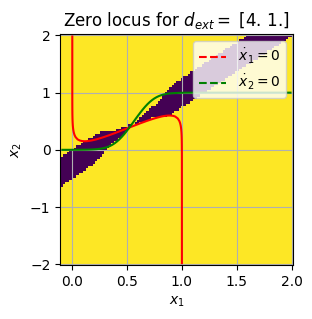

In [12]:
def jacobian_dynamics(x1,x2,d_ext):
    return np.array([[-1 + (5*a*np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))/(1 + np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))**2, (-4*a*np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))/(1 + np.exp(-a * (5*x1 - 4*x2 + d_ext[0] - theta)))**2], [(8*a*np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))/(1 + np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))**2, -1 + (-a*np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))/(1 + np.exp(-a * (8*x1 - x2 + d_ext[1] - theta)))**2]])


def plot_zero_locus_stabilite(d_ext):
    N = 100
    grid_x1 = np.linspace(-0.1,2.0,N)
    grid_x2 = np.linspace(-2.0,2.0,N)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    # compute trace and determinant of jacobian matrix on the grid
    tr = np.zeros((N,N))
    deter = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            tr[i,j] = np.trace(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))
            deter[i,j] = np.linalg.det(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))

    # plot zone where  the trace of the jacobian is negative and its determinant positive
    plt.figure()
    plt.pcolormesh(X1,X2,(tr<0)*(deter>0))

    # root locus plot
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()

    return

plot_zero_locus_stabilite(np.array([4.0,1.0]))

Si on a une jacobienne qui, en les points d'équilibre, a un déterminant $\leq$ 0 ou une trace positive, alors d'après le théorème du cours ces points d'équilibre sont instables. On veut donc que les courbes verte et rouge se croisent dans la zone violette (là où la jacobienne vérifie ces conditions). C'est le cas pour $d_{\rm ext}$ = (4.0, 1.0). On doit donc pouvoir observer un cycle limite pour cette valeur de $d_{\rm ext}$ grâce au programme suivant :

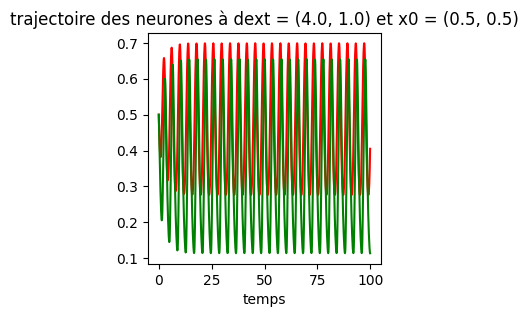

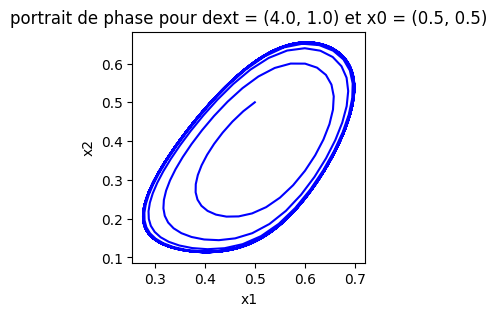

In [15]:
def f_d_ext_constant2(t, x):
    d_ext = np.array([4.0,1.0])
    return -x + sigmoid(np.dot(W,x)+d_ext)



dt = 0.1
t0, tf = 0.0, 100.0
x0 = np.array([0.5, 0.5])
time, x = solve_euler_explicit(f_d_ext_constant2, x0, dt, t0, tf)
plt.figure()
plt.plot(time,x[:,0], label = '1e variable de x', color="red")
plt.plot(time, x[:,1], label = '2e variable de x', color="green")
plt.title("trajectoire des neurones à dext = (4.0, 1.0) et x0 = (" + str(x0[0]) + ", " + str(x0[1]) + ")")
plt.xlabel("temps")
plt.show()
plt.figure()
plt.plot(x[:,0],x[:,1], color="blue")
plt.title("portrait de phase pour dext = (4.0, 1.0) et x0 = (" + str(x0[0]) + ", " + str(x0[1]) + ")")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

On observe bien une fonction periodique pour $x_1$ et $x_2$. On a trouvé le cycle limite !